### Multilabel Classification com Keras

O objetivo deste notebook é classificar a minha presença e/ou o da minha esposa, nas fotos do nosso casamento.
Comparamos o desempenho de abordagens treinando uma rede convolucional do inicio, com Keras, para fazer a classificação e fazendo fine-tuning de uma rede pré-treinada.

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

import re
import os
import cv2 as cv

2023-03-03 11:28:11.145825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/oracle/instantclient_19_9:
2023-03-03 11:28:11.145848: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Importa dados

In [2]:
BATCH_SIZE = 32

# Entrada da rede e tamanho das imagens
input_shape = (150, 150, 3)

In [3]:
def structure_images(path_to_subset):
    
    # Listas pra salvar as imagens e rotulos
    X = []
    Y = []

    # Itera sobre as classes no diretorio
    for folder in os.listdir(path_to_subset):

        # Le as imagens da classe e carrega em X e Y
        for image in os.listdir(os.path.join(path_to_subset, folder)):
            path_to_image = os.path.join(path_to_subset, folder, image)
            image = cv.imread(path_to_image)    
            image = cv.resize(image, (input_shape[0], input_shape[1]))
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            
            label = [folder]
            if '_' in folder:
                label = folder.split('_')

            X.append(image)
            Y.append(label)

    X = np.array(X)
    Y = np.array(Y)
    
    return(X, Y)

In [4]:
x_train, y_train = structure_images('./pessoas/train')

/tmp/ipykernel_1041495/2878669223.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y)


In [5]:
x_test, y_test = structure_images('./pessoas/test')

/tmp/ipykernel_1041495/2878669223.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y)


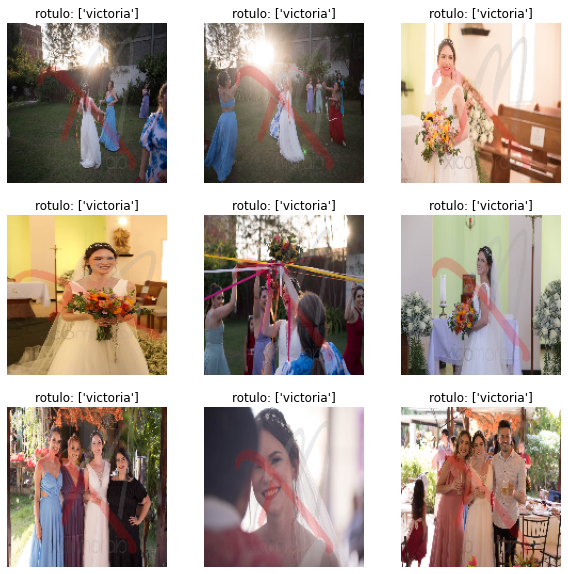

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i])
    plt.title('rotulo: ' + str(y_train[i]))
    plt.axis("off")
plt.show()

#### Formata rótulos pra classificacao multilabel

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, stratify = y_train, shuffle = True, random_state=3)

In [9]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1616, 150, 150, 3) (1616, 2)
(405, 150, 150, 3) (405, 2)
(683, 150, 150, 3) (683, 2)


#### Formata dados

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

2023-03-03 11:28:28.915844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dshome/venv/lib/python3.8/site-packages/cv2/../../lib64:/opt/oracle/instantclient_19_9:
2023-03-03 11:28:28.915870: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-03 11:28:28.915885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ec2-sa1-1b-p-analetslytics-dev): /proc/driver/nvidia/version does not exist
2023-03-03 11:28:28.916120: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the 

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.batch(BATCH_SIZE).repeat().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).repeat().prefetch(buffer_size=AUTOTUNE)

### Carrega funções de preprocessamento

In [12]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(input_shape[0], input_shape[1]),
    layers.Rescaling(1./255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

In [14]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# Classifica observacoes de teste
def predict_labels(model, x_test):
    preds = model.predict(x_test)
    preds = np.where(preds < 0.5, 0, 1)
    return(preds)

### Modela rede

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout

model = Sequential()

model.add(resize_and_rescale)
model.add(data_augmentation)

model.add(Conv2D(16, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(mlb.classes_), activation = 'sigmoid'))

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

optimizer = Adam() 
precision = Precision()
recall = Recall()

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[precision, recall])

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint pra salvar o melhor modelo
checkpoint = ModelCheckpoint('./best_model.hdf5', save_best_only = True, monitor = 'val_loss')

# Early Stopping pra evitar overfitting
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Ajustar o learning rate com Performance Scheduling
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    # steps_per_epoch=step_size_train,
    
    validation_data = val_dataset,
    # validation_steps=step_size_val,
    validation_steps=len(x_val) // BATCH_SIZE,
    
    epochs = 80, 
    callbacks = [checkpoint, early_stopping, lr_scheduler],
)

Epoch 1/80
50/50 [==============================] - 9s 163ms/step - loss: 0.8217 - precision: 0.8757 - recall: 0.5688 - val_loss: 0.7480 - val_precision: 0.9457 - val_recall: 0.4110 - lr: 0.0010
Epoch 2/80
50/50 [==============================] - 8s 156ms/step - loss: 0.6559 - precision: 0.8875 - recall: 0.6855 - val_loss: 1.7982 - val_precision: 0.9246 - val_recall: 0.3669 - lr: 0.0010
Epoch 3/80
50/50 [==============================] - 8s 155ms/step - loss: 0.5795 - precision: 0.8895 - recall: 0.7428 - val_loss: 2.1588 - val_precision: 0.9086 - val_recall: 0.5480 - lr: 0.0010
Epoch 4/80
50/50 [==============================] - 8s 155ms/step - loss: 0.4992 - precision: 0.8945 - recall: 0.8236 - val_loss: 2.4575 - val_precision: 0.9181 - val_recall: 0.4945 - lr: 0.0010
Epoch 5/80
50/50 [==============================] - 8s 155ms/step - loss: 0.4651 - precision: 0.8947 - recall: 0.8756 - val_loss: 2.0602 - val_precision: 0.9086 - val_recall: 0.5480 - lr: 0.0010
Epoch 6/80
50/50 [=======

#### Plota dados do treino

<AxesSubplot:>

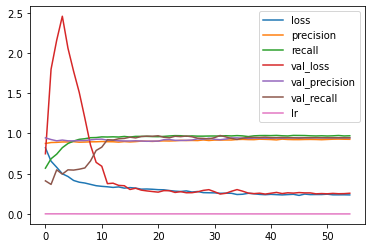

In [18]:
# Plot os resultados do treino
history = pd.DataFrame(history.history)
history.plot()

#### Carrega modelo 

In [19]:
# Load o melhor modelo
model.load_weights('./best_model.hdf5')

# Salva o modelo para usar depois
model.save('./best_model.hdf5')

#### Avalia modelo no teste

In [20]:
model_preds = predict_labels(model, x_test)

# Cria matriz de confusao
confusion = multilabel_confusion_matrix(y_test, model_preds)
confusion

array([[[147,  28],
        [ 44, 464]],

       [[ 16,  47],
        [  0, 620]]])

In [21]:
precision_recall_fscore_support(y_test, model_preds, average='micro')

(0.9352890422778257, 0.9609929078014184, 0.9479667686926103, None)

In [22]:
accuracy_score(y_test, model_preds)

0.8389458272327965

### Fine Tuning de rede pré-treinada

In [23]:
base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False)

In [24]:
base_model.trainable = False

In [25]:
inputs = tf.keras.Input(shape=input_shape)

x = data_augmentation(inputs)
x = resize_and_rescale(x)

# Executa em modo de inferencia (sem atualizar os pesos da rede pretreinada)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(2, activation = 'sigmoid')(x)
tl_model = tf.keras.Model(inputs, outputs)

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

optimizer = Adam() 
precision = Precision()
recall = Recall()
loss = tf.keras.losses.BinaryCrossentropy()
tl_model.compile(optimizer=optimizer, loss=loss, metrics=[precision, recall]) 


In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint pra salvar o melhor modelo
checkpoint = ModelCheckpoint('./best_model_tl.hdf5', save_best_only = True, monitor = 'val_loss')

# Early Stopping pra evitar overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Ajustar o learning rate com Performance Scheduling
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

tl_history_1 = tl_model.fit(
    train_dataset,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    
    validation_data = val_dataset,
    validation_steps=len(x_val) // BATCH_SIZE,
    
    epochs = 40, 
    callbacks = [checkpoint, early_stopping, lr_scheduler],
)

Epoch 1/40
50/50 [==============================] - 56s 1s/step - loss: 1.1240 - precision_1: 0.8698 - recall_1: 0.8921 - val_loss: 0.6813 - val_precision_1: 0.8944 - val_recall_1: 0.9071 - lr: 0.0010
Epoch 2/40
50/50 [==============================] - 54s 1s/step - loss: 0.4982 - precision_1: 0.9141 - recall_1: 0.9325 - val_loss: 0.3642 - val_precision_1: 0.9239 - val_recall_1: 0.9559 - lr: 0.0010
Epoch 3/40
50/50 [==============================] - 54s 1s/step - loss: 0.3078 - precision_1: 0.9356 - recall_1: 0.9524 - val_loss: 0.2461 - val_precision_1: 0.9360 - val_recall_1: 0.9669 - lr: 0.0010
Epoch 4/40
50/50 [==============================] - 54s 1s/step - loss: 0.2190 - precision_1: 0.9509 - recall_1: 0.9676 - val_loss: 0.1984 - val_precision_1: 0.9551 - val_recall_1: 0.9717 - lr: 0.0010
Epoch 5/40
50/50 [==============================] - 54s 1s/step - loss: 0.1689 - precision_1: 0.9608 - recall_1: 0.9725 - val_loss: 0.1757 - val_precision_1: 0.9641 - val_recall_1: 0.9717 - lr: 0.

<AxesSubplot:>

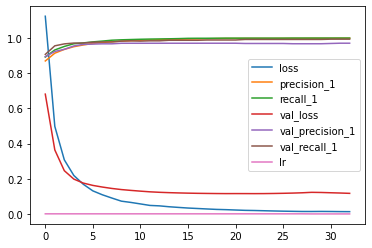

In [28]:
tl_history_1_df = pd.DataFrame(tl_history_1.history)
tl_history_1_df.plot()

In [29]:
# Load o melhor modelo
tl_model.load_weights('./best_model_tl.hdf5')

In [30]:
base_model.trainable = True

optimizer = tf.keras.optimizers.Adam(1e-5)  # Low learning rate
loss = tf.keras.losses.BinaryCrossentropy()
tl_model.compile(optimizer=optimizer, loss=loss, metrics=[precision, recall]) 

In [31]:
tl_history_2 = tl_model.fit(
    train_dataset,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    
    validation_data = val_dataset,
    validation_steps=len(x_val) // BATCH_SIZE,
    
    epochs = 5, 
    callbacks = [checkpoint, early_stopping, lr_scheduler],
)

Epoch 1/5
50/50 [==============================] - 208s 4s/step - loss: 0.0554 - precision_1: 0.9831 - recall_1: 0.9924 - val_loss: 0.1052 - val_precision_1: 0.9813 - val_recall_1: 0.9906 - lr: 1.0000e-05
Epoch 2/5
50/50 [==============================] - 206s 4s/step - loss: 0.0181 - precision_1: 0.9962 - recall_1: 0.9985 - val_loss: 0.0887 - val_precision_1: 0.9859 - val_recall_1: 0.9921 - lr: 1.0000e-05
Epoch 3/5
50/50 [==============================] - 205s 4s/step - loss: 0.0105 - precision_1: 0.9985 - recall_1: 0.9989 - val_loss: 0.0912 - val_precision_1: 0.9844 - val_recall_1: 0.9937 - lr: 1.0000e-05
Epoch 4/5
50/50 [==============================] - 205s 4s/step - loss: 0.0094 - precision_1: 0.9985 - recall_1: 0.9992 - val_loss: 0.1044 - val_precision_1: 0.9784 - val_recall_1: 1.0000 - lr: 1.0000e-05
Epoch 5/5
50/50 [==============================] - 205s 4s/step - loss: 0.0046 - precision_1: 0.9989 - recall_1: 0.9992 - val_loss: 0.0714 - val_precision_1: 0.9815 - val_recall_1:

In [32]:
# Load o melhor modelo
tl_model.load_weights('./best_model_tl.hdf5')

# Salva o modelo para usar depois
tl_model.save('./best_model_tl.hdf5')

<AxesSubplot:>

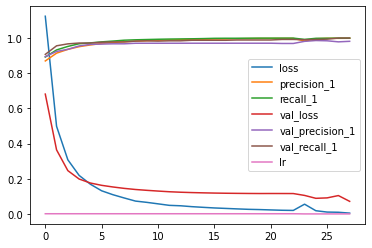

In [33]:
tl_history_2_df = pd.concat([tl_history_1_df.iloc[0:(tl_history_1_df.val_loss.idxmin()+1)], pd.DataFrame(tl_history_2.history)]).reset_index(drop=True)
tl_history_2_df.plot()

#### Avalia modelo TL no teste

In [34]:
tl_preds = predict_labels(tl_model, x_test)

# Cria matriz de confusao
confusion = multilabel_confusion_matrix(y_test, tl_preds)
confusion

array([[[160,  15],
        [  0, 508]],

       [[ 58,   5],
        [  2, 618]]])

In [35]:
precision_recall_fscore_support(y_test, tl_preds, average='micro')

(0.9825479930191972, 0.99822695035461, 0.990325417766051, None)

In [36]:
accuracy_score(y_test, tl_preds)

0.9677891654465594

#### Mostra imagens com classe real e prevista da melhor abordagem (Transfer Learning)

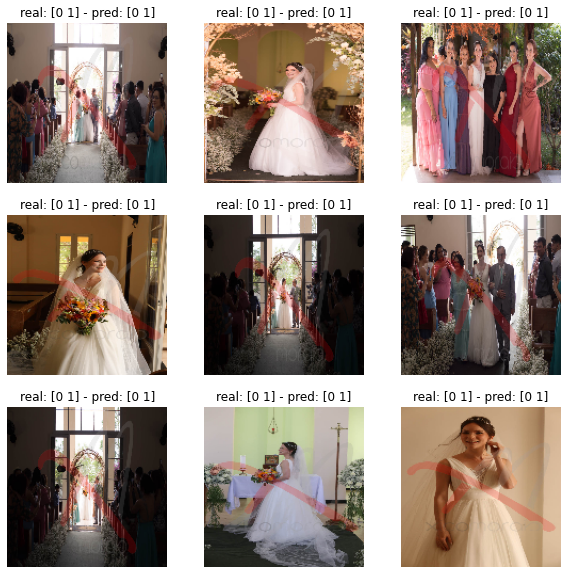

In [37]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_test[i])
    plt.title('real: ' + str(y_test[i])+ " - pred: "+ str(tl_preds[i]))
    plt.axis("off")
plt.show()

#### Previsoes problematicas

In [38]:
erro_allan = []
erro_victoria = []
erro_ambos = []
acerto = []
for i in range(0, len(y_test)):
    
    if np.array_equal(y_test[i], tl_preds[i]):
        acerto.append(i)
        continue
        
    if (y_test[i][0] != tl_preds[i][0]) & (y_test[i][1] != tl_preds[i][1]):
        erro_ambos.append(i)
        continue
        
    if (y_test[i][0] != tl_preds[i][0]):
        erro_allan.append(i)
        continue
    
    if (y_test[i][1] != tl_preds[i][1]):
        erro_victoria.append(i)
        continue
        

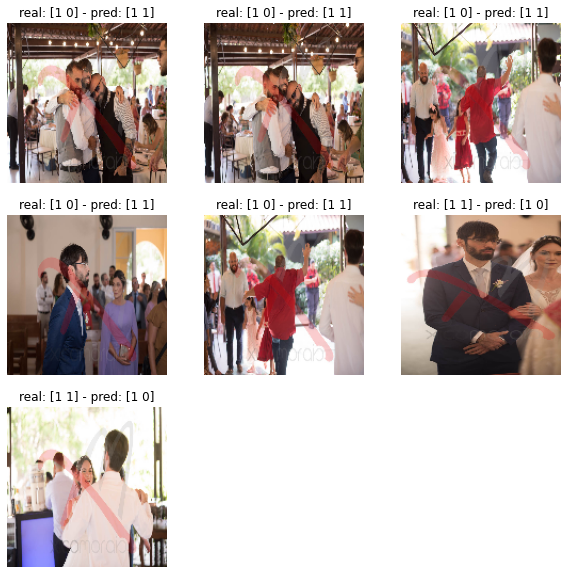

In [39]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(0,min(9,len(erro_victoria))):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_test[erro_victoria[i]])
    plt.title('real: ' + str(y_test[erro_victoria[i]])+ " - pred: "+ str(tl_preds[erro_victoria[i]]))
    plt.axis("off")
plt.show()


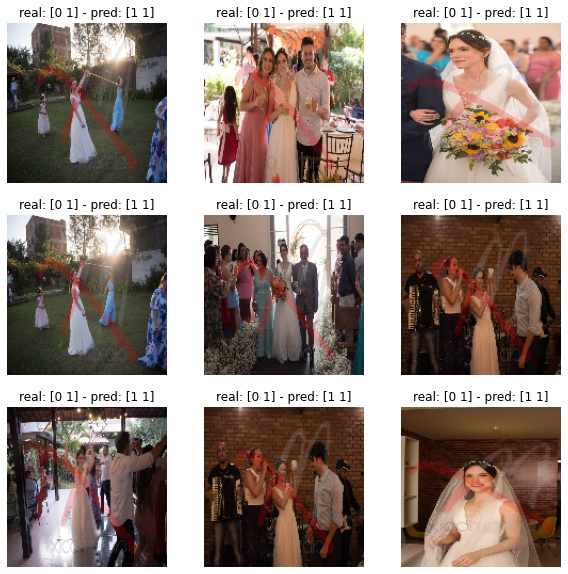

In [40]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(0,min(9,len(erro_allan))):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_test[erro_allan[i]])
    plt.title('real: ' + str(y_test[erro_allan[i]])+ " - pred: "+ str(tl_preds[erro_allan[i]]))
    plt.axis("off")
plt.show()


### Explicações das previsões (LIME)

In [41]:
from lime import lime_image
import time

from skimage.segmentation import mark_boundaries

In [42]:
explainer = lime_image.LimeImageExplainer()

#### Acerto

In [43]:
tmp = time.time()

explanation_acerto = explainer.explain_instance(x_test[acerto[1]]/255., tl_model.predict, top_labels=2, hide_color=0, num_samples=1000)
print(time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

31.01556134223938


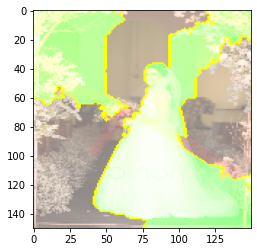

In [44]:
temp_acerto_allan, mask_acerto_allan = explanation_acerto.get_image_and_mask(explanation_acerto.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_acerto_allan / 2 + 0.5, mask_acerto_allan))

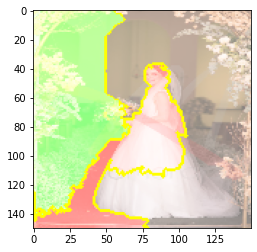

In [45]:
temp_acerto_victoria, mask_acerto_victoria = explanation_acerto.get_image_and_mask(explanation_acerto.top_labels[1], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_acerto_victoria / 2 + 0.5, mask_acerto_victoria))

#### Erro allan

In [46]:
predict_labels(tl_model, x_test[erro_allan[0:1]])

array([[1, 1]])

In [47]:
tmp = time.time()

explanation_er_al = explainer.explain_instance(x_test[erro_allan[0]]/255., tl_model.predict, hide_color=None, num_samples=1000)
print(time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

31.485507011413574


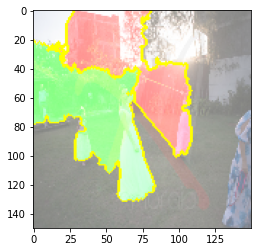

In [48]:
temp_er_al_al, mask_er_al_al = explanation_er_al.get_image_and_mask(explanation_er_al.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_er_al_al / 2 + 0.5, mask_er_al_al))

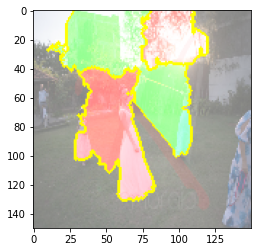

In [49]:
temp_er_al_vi, mask_er_al_vi = explanation_er_al.get_image_and_mask(explanation_er_al.top_labels[1], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_er_al_vi / 2 + 0.5, mask_er_al_vi))

#### Erro Victoria

In [50]:
predict_labels(tl_model, x_test[erro_victoria[0:1]])

array([[1, 1]])

In [51]:
tmp = time.time()

explanation_er_vi = explainer.explain_instance(x_test[erro_victoria[0]]/255., tl_model.predict, hide_color=None, num_samples=1000)
print(time.time() - tmp)

  0%|          | 0/1000 [00:00<?, ?it/s]

30.84239101409912


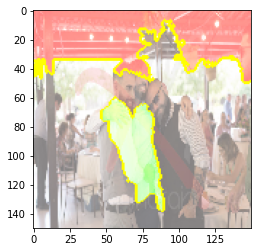

In [52]:
temp_er_vi_al, mask_er_vi_al = explanation_er_vi.get_image_and_mask(explanation_er_vi.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_er_vi_al / 2 + 0.5, mask_er_vi_al))

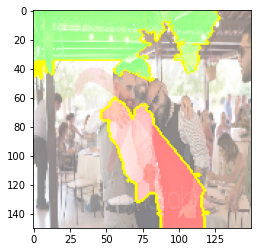

In [53]:
temp_er_vi_vi, mask_er_vi_vi = explanation_er_vi.get_image_and_mask(explanation_er_vi.top_labels[1], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp_er_vi_vi / 2 + 0.5, mask_er_vi_vi))